# How to interpolate 2D spatial data with kriging in Python?

Reference : https://stackoverflow.com/questions/59330497/how-to-interpolate-2d-spatial-data-with-kriging-in-python

I have a spatial 2D domain, say [0,1]x[0,1]. In this domain, there are 6 points at known locations where some observed parameter value (e.g. a temperature, a mechanical stress, a fluid density, etc...) is given. How to predict the parameter value at points where there is no observation i.e. how may I interpolate the data in Python?

With OpenTURNS, the `GaussianProcessFitter` class can estimate the hyperparameters of the conditioned gaussian process with known inputs and outputs. In this example, the inputs are the coordinates and the outputs are the observed parameter values. Once these hyperparameters are estimated, the getMetamodel method returns a function which interpolates the data.

The following script converts the Numpy arrays into OT's Samples. For the observations, the second parameter, equal to 1 sets the dimension of the Sample (in order to avoid an ambiguous conversion from a 1D array).

In [1]:
import openturns as ot
import numpy as np
import openturns.experimental as otexp

In [2]:
coordinates = np.array(
    [[0.0, 0.0], [0.5, 0.0], [1.0, 0.0], [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]]
)
observations = np.array([1.0, 0.5, 0.75, -1.0, 0.0, 1.0])

The x and y coordinates can be extracted with:

In [3]:
x = coordinates[:, 0]
y = coordinates[:, 1]

The following script creates a scatter plot where the color represents the value of the parameter.

In [4]:
%matplotlib inline

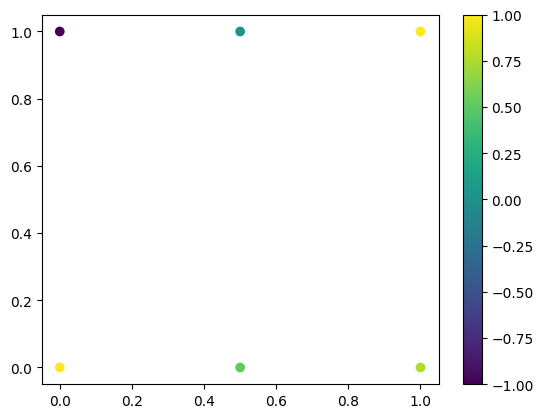

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.scatter(x, y, c=observations, cmap="viridis")
plt.colorbar()
plt.show()

The following script converts the Numpy arrays into OT's Samples. For the observations, the second parameter, equal to 1 sets the dimension of the Sample (in order to avoid an ambiguous conversion from a 1D array).

In [6]:
input_train = ot.Sample(coordinates)
output_train = ot.Sample([[x] for x in observations])

Then we create a conditioned gaussian process with a constant trend and a squared exponential covariance model.

In [7]:
# Fit
inputDimension = 2
basis = ot.ConstantBasisFactory(inputDimension).build()
covarianceModel = ot.SquaredExponential([1.0] * inputDimension, [1.0])
fitter = otexp.GaussianProcessFitter(input_train, output_train, covarianceModel, basis)
fitter.run()
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()
gpr_result = gpr.getResult()
krigingMetamodel = gpr_result.getMetaModel()

Once done, the krigingMetamodel variable is a Function which takes as input a 2D Point representing the coordinates and returns a 1D Point representing the parameter value. To illustrate this, I first create the 2D domain [0,1]x[0,1] and create a 2D discretization of it with a regular grid.

In [8]:
# Create the 2D domain
myInterval = ot.Interval([0.0, 0.0], [1.0, 1.0])
# Define the number of interval in each direction of the box
nx = 20
ny = 10
myIndices = [nx - 1, ny - 1]
myMesher = ot.IntervalMesher(myIndices)
myMeshBox = myMesher.build(myInterval)

Using the kriging metamodel to predict the parameter value on this mesh can be done with the following statements. We first get the vertices of the mesh as a Sample, then evaluate the predictions with one single call to the metamodel (there is no need for a for loop here).

In [9]:
# Predict
vertices = myMeshBox.getVertices()
predictions = krigingMetamodel(vertices)

In order to see the result with Matplotlib, we first have to create the data required by the pcolor function.

In [10]:
# Format for plot
X = np.array(vertices[:, 0]).reshape((ny, nx))
Y = np.array(vertices[:, 1]).reshape((ny, nx))
predictions_array = np.array(predictions).reshape((ny, nx))

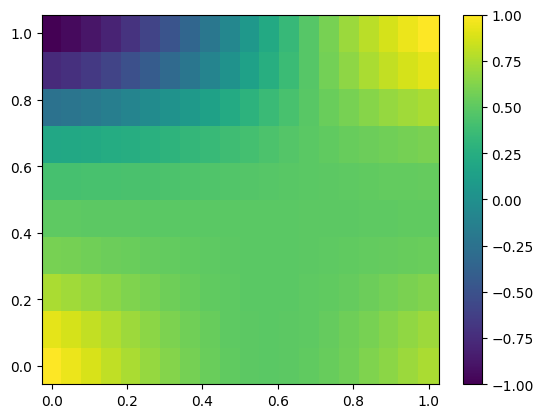

In [11]:
# Plot
fig = plt.figure()
plt.pcolor(X, Y, predictions_array, shading="auto")
plt.colorbar()
plt.show()

We see that the predictions of the metamodel are equal to the observations at the coordinates where the parameter values are known. On other points, the metamodel is a regular function of the coordinates : this regularity is a consequence of the choice of the covariance model.